<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/AutoKeras_Auto_model_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import library and check GPU

In [ ]:
pip install autokeras

In [8]:
import matplotlib.pyplot as plt
# import autokeras as ak
import tensorflow as tf
from tensorflow.keras.datasets import cifar10 

In [7]:
# check GPU is available
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Preparing the CIFAR-10 dataset

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train: ', x_train.shape) 
print('y_train: ', y_train.shape)
print('x_test: ', x_test.shape) 
print('y_test: ', y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
x_test:  (10000, 32, 32, 3)
y_test:  (10000, 1)


In [ ]:
x_train[0] , y_train[0]

(array([[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],
 
        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],
 
        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],
 
        ...,
 
        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],
 
        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],
 
        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
  

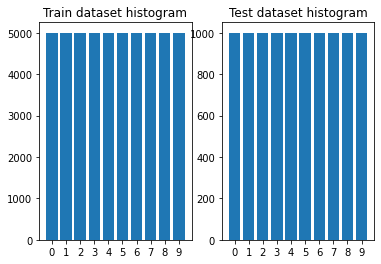

In [ ]:
import numpy as np

train_histogram = np.histogram(y_train)
test_histogram = np.histogram(y_test)
_, axs = plt.subplots(1, 2)
axs[0].set_xticks(range(10))
axs[0].bar(range(10), train_histogram[0])
axs[0].set_title('Train dataset histogram')
axs[1].set_xticks(range(10))
axs[1].bar(range(10), test_histogram[0])
axs[1].set_title('Test dataset histogram')
plt.show()

### Model settings
Nodes: https://autokeras.com/node/  
根據不同輸入類型,使用不同API,如ImageInput, TextInput etc.

Block: https://autokeras.com/block/  
可使用預先定義好的block,免去model重頭到尾做NAS,block包含convolution layer及classification layer(ClassificationHead)

#### Method1 指定搜尋範圍為EfficientNet (B0~B7)

In [ ]:
# callbacks
callbacks = [ tf.callbacks.EarlyStopping(patience=2) ]

# node costruction
# image input
input_node = ak.ImageInput()

# main model layers 
# efficient = EfficientNet
output_node = ak.ImageBlock(block_tpye = 'efficient'
                           normalize = True,
                           augment = False)(input_node)

# classification layer
output_node = ak.ClassificationHead()(output_node)

# compile & fit
clf = ak.AutoModel(inputs=input_node, 
                   outputs=output_node, 
                   max_trials=10)
clf.fit(x_train, y_train, callbacks=callbacks)

#### Method2 進階搜尋, 指定搜尋範圍為EfficientNet B7  
Augments:  
pretrained=True,即使用pretrained weights進行Transfer learning  
tuner: 預設搜尋超參數時的方法, https://autokeras.com/auto_model/
額外增加normalization, pooling ,drop=0 來減少參數量以加快計算

In [9]:
# callbacks
callbacks = [ tf.keras.callbacks.EarlyStopping(patience=2) ]

# node costruction
# image input
input_node = ak.ImageInput()

# main model layers 
# efficient = EfficientNet
output_node = ak.Normalization()(input_node) # normalization
output_node = ak.EfficientNetBlock(version='b7',
                                   pretrained=True)(output_node)

output_node = ak.SpatialReduction(reduction_type='global_avg')(output_node) # pooling 

# classification layer
output_node = ak.ClassificationHead(dropout=0)(output_node) # dropout=0

# compile & fit
clf = ak.AutoModel(inputs=input_node, 
                   outputs=output_node, 
                   # tuner='bayesian',
                   max_trials=2)
clf.fit(x_train, y_train, batch_size=128, callbacks=callbacks, epochs=10)

Trial 2 Complete [00h 43m 49s]
val_loss: 1.2860339879989624

Best val_loss So Far: 1.2860339879989624
Total elapsed time: 00h 51m 22s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
391/391 [==============================] - 307s 688ms/step - loss: 2.2441 - accuracy: 0.1781
Epoch 2/10
391/391 [==============================] - 267s 683ms/step - loss: 1.9205 - accuracy: 0.3060
Epoch 3/10
391/391 [==============================] - 267s 683ms/step - loss: 1.6810 - accuracy: 0.3991
Epoch 4/10
391/391 [==============================] - 267s 684ms/step - loss: 1.4983 - accuracy: 0.4672
Epoch 5/10
391/391 [==============================] - 267s 684ms/step - loss: 1.3666 - accuracy: 0.5125
Epoch 6/10
391/391 [==============================] - 267s 683ms/step - loss: 1.2541 - accuracy: 0.5577
Epoch 7/10
391/391 [==============================] - 265s 679ms/step - loss: 1.1586 - accuracy: 0.5908
Epoch 8/10
391/391 [==============================] - 266s 679ms/step - loss: 1.0764 - accuracy: 0.6

In [11]:
clf.evaluate(x_test, y_test, batch_size=64)

157/157 [==============================] - 43s 223ms/step - loss: 1.2090 - accuracy: 0.5834


[1.2090259790420532, 0.5834000110626221]

### Export Keras model

In [12]:
model = clf.export_model()
model.save('cifar_best_model')

INFO:tensorflow:Assets written to: cifar_best_model/assets


### Load model

In [ ]:
from tensorflow.keras.models import load_model
keras_model = load_model('cifar_best_model', custom_objects=ak.CUSTOM_OBJECTS) 
# custom_object setting使model為AutoKeras model 與一般Keras model還是有不同

# keras_model.evaluate(x_test, y_test, ) # y_test需先做one-hot

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
!cp -r cifar_best_model /content/drive/MyDrive/model/AutoKeras/AutoModel_CIFAR10

In [25]:
x_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

In [18]:
keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                             

### Prediction

In [19]:
predicted = keras_model.predict(x_test)
predicted # numpy array

array([[1.7356062e-02, 3.9509214e-03, 1.2304490e-01, ..., 6.2023118e-02,
        7.3269457e-03, 8.1152553e-03],
       [8.5409515e-04, 1.8594846e-02, 4.7278937e-04, ..., 9.7386706e-05,
        8.7520289e-01, 1.0441978e-01],
       [1.2644620e-01, 4.3159202e-01, 5.4206243e-03, ..., 9.8261498e-03,
        3.4898710e-01, 5.5047885e-02],
       ...,
       [6.5626999e-05, 1.5368704e-04, 1.7201951e-03, ..., 9.9418443e-03,
        1.2533585e-04, 1.6952987e-03],
       [2.1143968e-01, 2.4906275e-01, 3.0531070e-01, ..., 1.3504788e-02,
        4.1659627e-02, 1.0563077e-02],
       [6.4341580e-03, 5.9484021e-04, 2.0149667e-03, ..., 8.1554145e-01,
        6.5045373e-04, 7.3649641e-04]], dtype=float32)

In [20]:
predicted_classes = predicted.argmax(axis=1)
predicted_classes # arg max

array([5, 8, 1, ..., 5, 2, 7])

### Detail report on classes

In [21]:
from sklearn.metrics import classification_report

# labels 
labels = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(classification_report(y_test, predicted_classes, target_names=labels))

              precision    recall  f1-score   support

    airplane       0.62      0.71      0.66      1000
  automobile       0.68      0.66      0.67      1000
        bird       0.50      0.42      0.45      1000
         cat       0.39      0.39      0.39      1000
        deer       0.54      0.51      0.52      1000
         dog       0.47      0.50      0.48      1000
        frog       0.67      0.71      0.69      1000
       horse       0.64      0.64      0.64      1000
        ship       0.71      0.67      0.69      1000
       truck       0.61      0.64      0.62      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000

